# Qunatum oscillations predictions
Predicted and DFT formation energy as a function of the distance between the defects for $\text{MoS}_2$ with one $\text{Mo}$ and one $\text{S}$ vacancy for the models with both tuned and default hyperparameter values. The baseline approaches fail to meaningfully learn the dependence, while sparse representation succeeds perfectly, including the non-monotonous quantum oscillations at 5Å.

In [3]:
import getpass
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from ai4mat.data.data import StorageResolver, read_trial

targets = ["formation_energy_per_site"]
results = []

with open("../scripts/ASPIRE-1/MoS2_V2_E.txt", "rt") as definitions_file:
    for line in definitions_file:
        trial, target, n_repeats, _, experiment = line.strip().split()
        for i in range(1, int(n_repeats) + 1):
            these_results = read_trial(experiment, f"stability/{trial}/{i}", True, targets, True)
            if len(these_results) > 0:
                these_results["trial_family"] = trial
                these_results["trial_index"] = i
                results.append(these_results)

results_pd = pd.concat(results, axis=0)

folded_predictions = results_pd.loc[
    ("formation_energy_per_site", "combined"),
    ("trial_family", "trial_index", "predictions")].set_index(
        ["trial_family", "trial_index"]).squeeze()

predictions_list = []
for (trail_family, trial_index), these_predictions in folded_predictions.items():
    prediction_frame = these_predictions.to_frame()
    prediction_frame["trial_family"] = trail_family
    prediction_frame["trial_index"] = trial_index
    prediction_frame.set_index(["trial_family", "trial_index", prediction_frame.index], inplace=True)
    predictions_list.append(prediction_frame.squeeze())

predictions_pd = pd.concat(predictions_list, axis=0)

structures = pd.read_pickle(StorageResolver()["processed"]/"low_density_defects/MoS2/data.pickle.gz").reindex(predictions_pd.index.get_level_values('_id').unique())

from operator import methodcaller
distances = structures.defect_representation.apply(methodcaller("get_distance", 0, 1))

true_energies = structures.formation_energy_per_site

distance_order = distances.argsort()

labels = {
    "schnet/25-11-2022_16-52-31/71debf15": "SchNet, tuned",
    "schnet/base": "SchNet, default",
    "catboost/29-11-2022_13-16-01/02e5eda9": "CatBoost, tuned",
    "catboost/base": "CatBoost, default",
    'gemnet/16-11-2022_20-05-04/b5723f85': "GemNet, tuned",
    "gemnet/base": "GemNet, default",
    "megnet_pytorch/25-11-2022_11-38-18/1baefba7": "MegNet (full), tuned",
    'megnet_pytorch/full/base': "MegNet (full), default",
    "megnet_pytorch/sparse/base": "MegNet (sparse), default",
    "megnet_pytorch/sparse/d6b7ce45_no_resample": "MegNet (sparse), tuned",
    "high_to_V2": "Tuned MegNet (sparse),\ntrained on high-density MoS$_2$ only"
}

predictions_pd.index.get_level_values("trial_family").unique()

fig, ax = plt.subplots(figsize=(6, 5))
for trial_family, family_predictions in predictions_pd.groupby(level="trial_family"):
    prediction_mean = family_predictions.groupby(level="_id").mean()
    prediction_std = family_predictions.groupby(level="_id").std()
    if prediction_std.isna().any():
        ax.scatter(distances, prediction_mean, label=labels[trial_family])
    else:
        ax.errorbar(distances, prediction_mean, yerr=prediction_std, label=labels[trial_family], fmt="*")
ax.plot(distances[distance_order], true_energies[distance_order], label="DFT")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=4)
ax.set_xlabel("Distance (Å)")
ax.set_ylabel("Formation energy (eV/site)")
plt.tight_layout()
fig.savefig("MoS2_V2.pdf")

FileNotFoundError: [Errno 2] No such file or directory: '/home/coder/project/ai4material_design_github/notebooks/../datasets/experiments/MoS2_V2/config.yaml'

Same data, but with tuned and default models on separate plots.

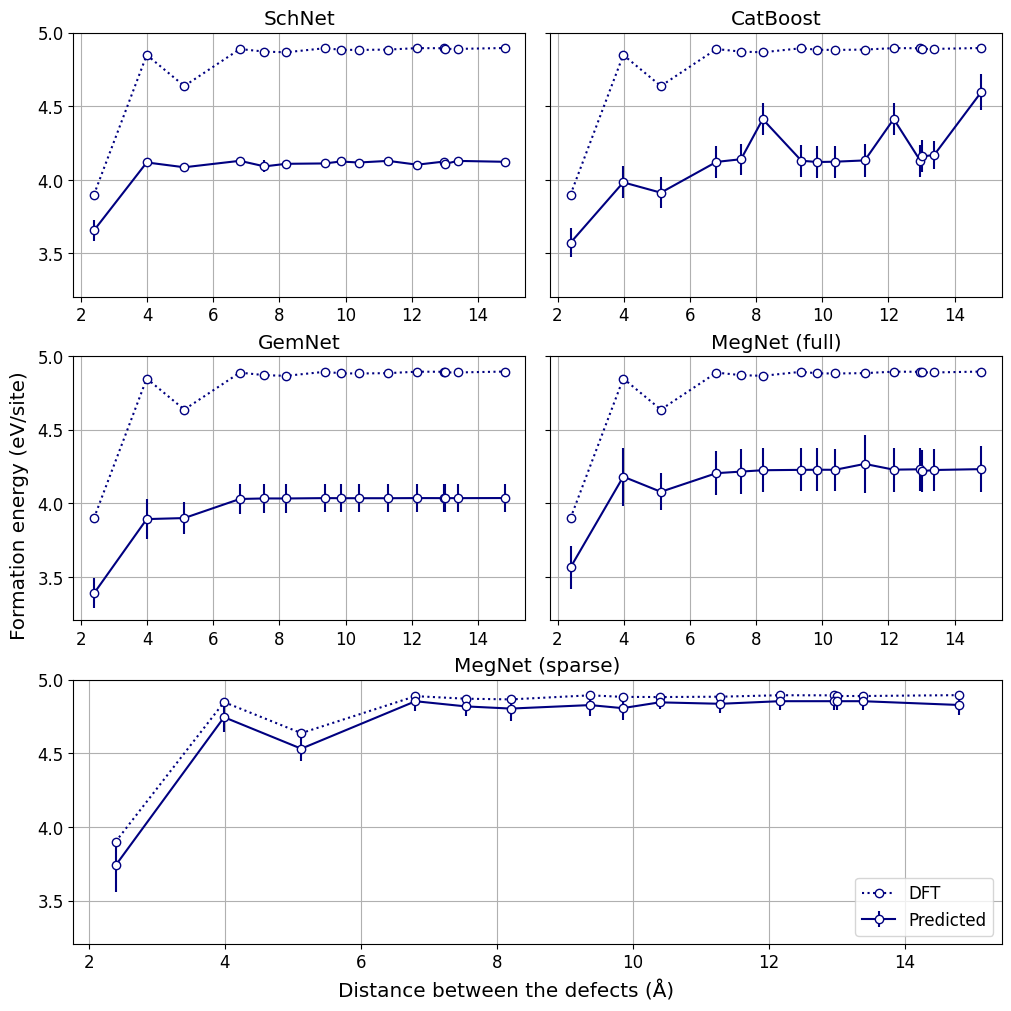

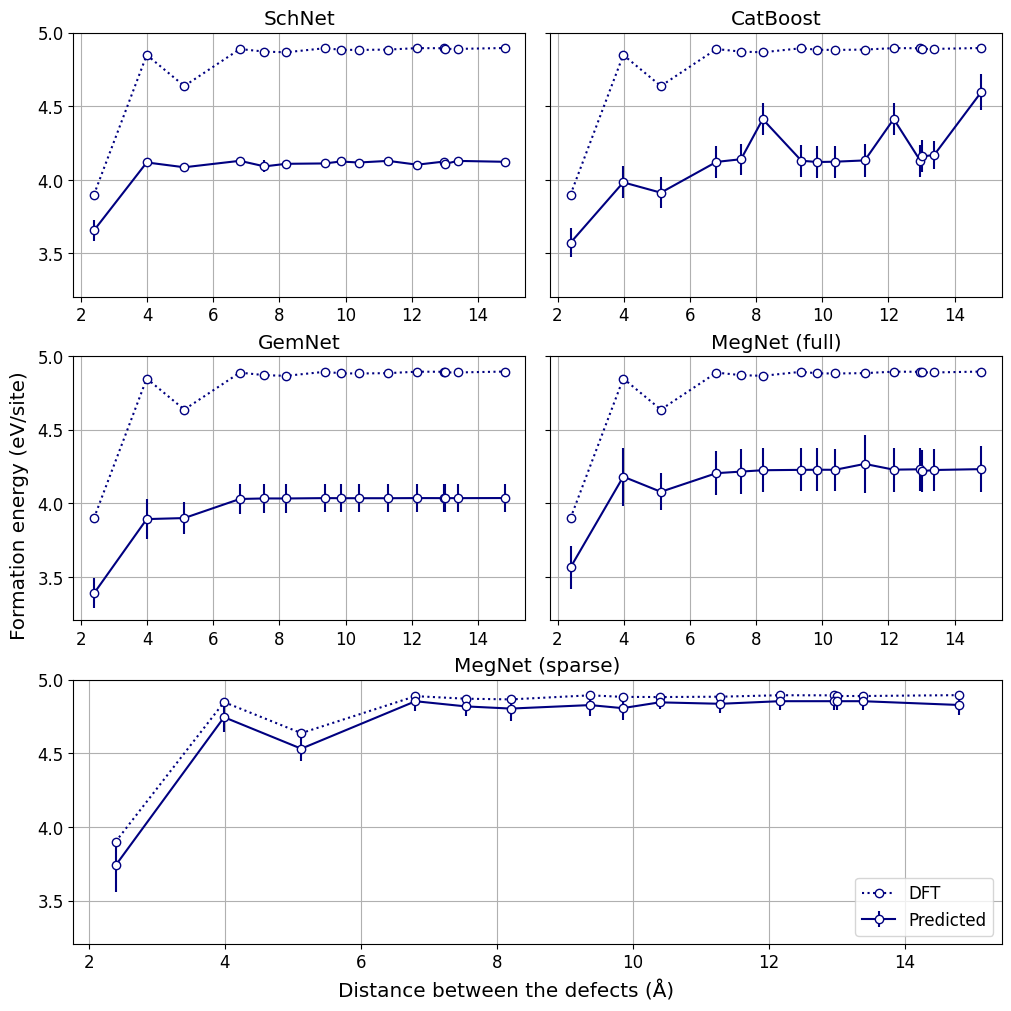

In [ ]:
font = {
        'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)


metadata = {
    "Title": "Energy as a function of ditance between defects in MoS2",
    "Keywords": "2D materials, machine learning, graph neural network, point defects"}

def plot_runs(runs, save_name):
        fig, axs = plt.subplot_mosaic([['upper left', 'upper right'],
                               ['middle left', 'middle right'],
                               ['lower', 'lower']],
                               figsize=(10, 10), constrained_layout=True, sharex=False, sharey=True)
        for i, (ax, (trial_family, name)) in enumerate(zip(axs.values(), paper_main.items())):
                family_predictions = predictions_pd.loc[trial_family]
                prediction_mean = family_predictions.groupby(level="_id").mean()
                prediction_std = family_predictions.groupby(level="_id").std()
                if prediction_std.isna().any():
                        predicted = ax.scatter(distances[distance_order], prediction_mean[distance_order], label="Predicted", color="navy", marker='o')
                else:
                        predicted = ax.errorbar(distances[distance_order],
                                                prediction_mean[distance_order],
                                                yerr=prediction_std[distance_order],
                                                color='navy', fmt='o-', mfc='white')
                dft = ax.plot(distances[distance_order], true_energies[distance_order], label="DFT", color="navy", marker='o', linestyle=':',mfc='white')
                ax.grid()
                ax.set_title(name)
                if i == 4:
                        predicted.set_label("Predicted")
                        dft[0].set_label("DFT")
                        ax.legend(loc="lower right")
        fig.supxlabel("Distance between the defects (Å)")
        fig.supylabel("Formation energy (eV/site)")
        fig.savefig(save_name, metadata=metadata)
        
paper_main = {
    "schnet/25-11-2022_16-52-31/71debf15": "SchNet",
    "catboost/29-11-2022_13-16-01/02e5eda9": "CatBoost",
    'gemnet/16-11-2022_20-05-04/b5723f85': "GemNet",
    "megnet_pytorch/25-11-2022_11-38-18/1baefba7": "MegNet (full)",
    "megnet_pytorch/sparse/d6b7ce45_no_resample": "MegNet (sparse)",
}
paper_si = {
    "schnet/base": "SchNet",
    "catboost/base": "CatBoost",
    "gemnet/base": "GemNet",
    'megnet_pytorch/full/base': "MegNet (full)",
    "megnet_pytorch/sparse/base": "MegNet (sparse)",
}
plot_runs(paper_main, "MoS2_V2_tuned.pdf")
plot_runs(paper_si, "MoS2_V2_default.pdf")

The local minima in the interaction energy correspond to the configurations when the $\text{S}$ vacancies are at the 1st, 3rd, 6th, and 10th nearest $\text{S}$ sites to the $\text{Mo}$ vacancy. These are exactly the triangular number series $S_n = n \cdot (n+1)/2$. Interestingly, the sites which exhibit local minima of the formation energy lie exactly along the zigzag crystalline orientation, as shown in the inset of figure below.

![Energy as a function of distance in MoS2 with Mo and S vacancies, along with the corresponding sites numbered in a zig-zag pattern](honeycomb_oscillations.webp)

In metals, the introduction of impurities generally results in Friedel oscillations. Due to the strong screening of the surrounding electrons, the long-range tail of a charged impurity potential is suppressed, resulting in a power law decay of the defect disturbance. In insulators, however, when the wave function is strongly localized on the defect site—the lattice structure plays a significant role in the defect properties. In crystals with a honeycomb structure, the interaction between defects is strongly influenced by the presence of the two sublattices. Thus, it has been predicted and confirmed both by theory and experiment that the coupling between hydrogen atoms on the surfaces of graphene depends on the sublattices occupied.

Please cite the following paper if you reuse materials on this webpage:

Huang, P., Lukin, R., Faleev, M. et al. Unveiling the complex structure-property correlation of defects in 2D materials based on high throughput datasets. npj 2D Mater Appl 7, 6 (2023). https://doi.org/10.1038/s41699-023-00369-1